# HW \#3: Policy Gradient: PPO

**Name: **  <font color="red">Alexander Johnston</font>



In this assignment, you are replacing VFA with a policy gradient method, proximal policy optimization.



##Note, i did not complete the assignment as my model was not successful, i just submitted for partial credit. My model did not successfully beat lunar lander. I am submitting for partial credit with my answers to the questions.

# I. Overview

The objective of this assignment is to train a PPO (Proximal Policy Optimization) model to achieve a succesful score against the Gymnasium Lunar Lander Task. I used the torch library to achieve this.

Files in this assignment:

assign3.ipynb - answers to all question + my code run

## Explanation of the Lunar Lander Problem

Simple Idea: The agent controls a space craft/lunar landerr that needs to safely land the lander on an area between 2 flags. This means the conditions for victory are: landing safely, and landing between the 2 flags.


Environmental factors:
-Gravity
-Damage from collision
-Thrust from engines
-Landing safely reqs

The game has 4 discrete actions
-do nothing
-fire left engine
-fire main engine
-fire right engine

The problem explains that due to Pontyagin's maximum principle, its optimal to fire at full throttle or turn it off, which is why the action space is as small as it is.


Episodes are equivilent to 1 instance of the lunar lander. The simulation continues until either the lander has reached the space between the 2 flags safely, or has crashed, as it is given infinite fuel. This means it could win first try as long as it doesn't crash.

It said the state is an 8 dimension vector, containing coordinates, velocities, angular velocity, angle, and booleans stating if either leg is in contact with the ground. This feels a lot different from the previous ones where i was feeding it the frame data.

To emulate success, the model is rewarded/punished for the following:
-1 Frame of using main engine - -.3
-1 Frame of using side engine - -.03
-Crash - -100 
-Safely Lands - +100
-Solved (Safely lands between 2 flags) - +200


My aims is to score as many points as possible, which requires spending as little time in air as possible while landing safely on the first attempt. The model must come to understand the meaning of the various values in the state vector and learn how the correlate with success and failuire.

# II. Problem


## Lunar Lander


https://gymnasium.farama.org/environments/box2d/lunar_lander/

![lunar lander](https://gymnasium.farama.org/_images/lunar_lander.gif)




#### STEPS for Lunar Lander

1. [II Problems] First, import gymnasium (if you haven't installed it, make sure install gymnasium first.
1. [II Problems] Initialize, learn and test how the environment works.
1. [II Problems] Explain the environment code.
3. [III Methods] Build your PPO.
4. [III Methods] Explain your RL agent (PPO) with review of PG and PPO and how it is implemented.
5. [IV Results]  Discuss your hyperparameter search process.
5. [IV Results]  Explain your final setup and discuss the agent's performance.




## Explain Environment code


## All of my code is in the 1 block below

I will explain the environment code here.

I initialized the lunar lander with env = gym.make("LunarLander-v3")

obs_dim and act_dim represent the input and output layers

next_obs, reward, truncated, and terminated store data from the environment and are used to feed data into the model.

lastly, env.reset() resets the environment

# III. Methods

- Describe your PPO model and neural network architecture.
- Describe your approach and the reason why you select it (i.e., explain the network architecture and why you chose it).
- Explain your codes.

My ppo model contains the followi9ng:

2 hidden layers with tanh activation (64)

Logits for action distribution.

Value head outputs the state value.

The model class initialized a shared network with 2 hidden layers and 2 outputs, which were polciy and value head. Forward passed input through these layers and the logits for the aciton probabilities. Act would compute the logits and value, then sample an action from a Categorical distribution.

Rollout Buffer created the buffer that stored data relating to the environment and replaced it after each PPO update. After each update it would clear itself, allowing for a new fresh run with the new policy.

compute_gae did the Generalized Advantage Estimation which I saw as a commonly used way to find variance in advantage. 


For the training process, it initializes the environment and initializes the model and rollout buffer. Everytime it reaches a certain number of steps, it updates the policy with the information stored in the buffer. the algorithm calcs adv using gae. It performs multiple epochs of optimization using a variety of variables to enhance stability. Throughout this, I record episode rewards, lengths, and other data to track how its doing.

Lastly, I use matplotlib to plot my relevant charts.



Using device: cuda
CREATE ENV
Observation dimension: 8, Action dimension: 4
Starting training loop...

Performing PPO update at timestep 4000...
PPO update completed. Loss: 700.449
Average episode reward (last 10 episodes): -248.90

Performing PPO update at timestep 8000...
PPO update completed. Loss: 687.011
Average episode reward (last 10 episodes): -222.11

Performing PPO update at timestep 12000...
PPO update completed. Loss: 723.957
Average episode reward (last 10 episodes): -250.24

Performing PPO update at timestep 16000...
PPO update completed. Loss: 658.827
Average episode reward (last 10 episodes): -209.04

Performing PPO update at timestep 20000...
PPO update completed. Loss: 649.557
Average episode reward (last 10 episodes): -162.69

Performing PPO update at timestep 24000...
PPO update completed. Loss: 711.045
Average episode reward (last 10 episodes): -172.08

Performing PPO update at timestep 28000...
PPO update completed. Loss: 596.441
Average episode reward (last 10 ep

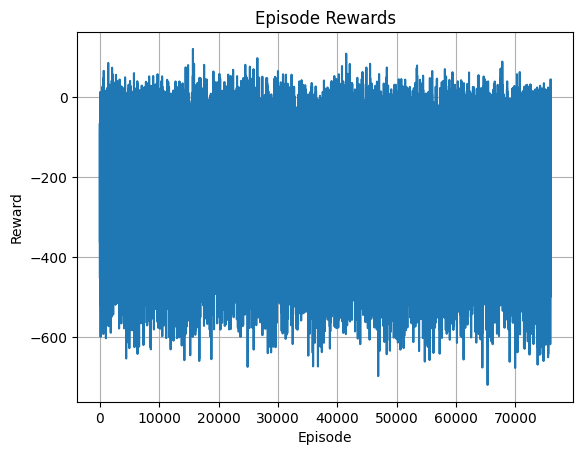

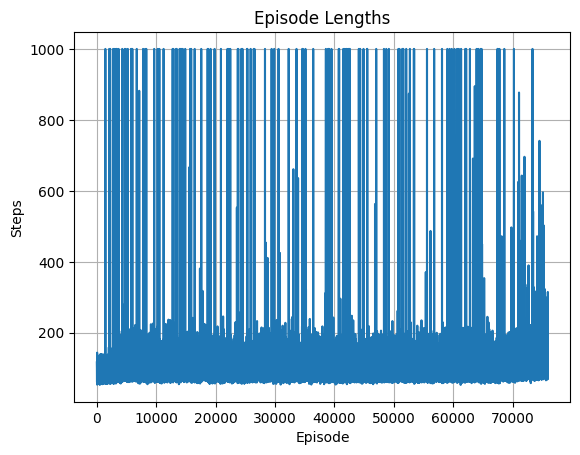

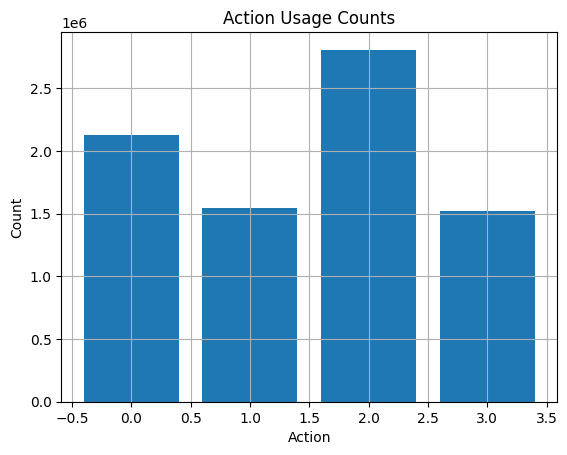

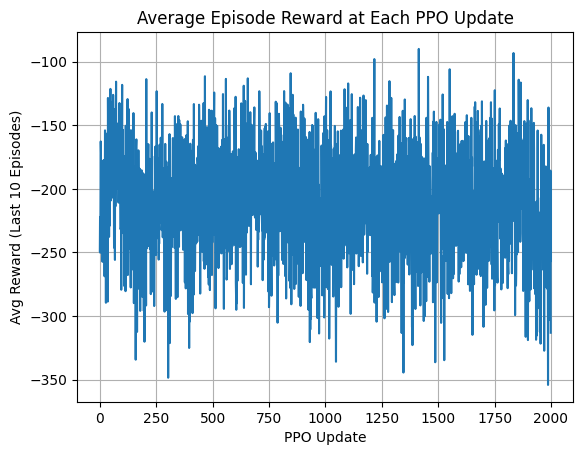

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

lr = 1e-4
gamma = 0.95
gae_lambda = 0.95
eps_clip = 0.2
K_epochs = 4
update_timestep = 4000
max_timesteps = 8000000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Model(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(Model, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self.policy_head = nn.Linear(64, act_dim)
        self.value_head = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.shared(x)
        return self.policy_head(x), self.value_head(x)
        
    def act(self, obs):
        logits, value = self.forward(obs)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy(), value
        
    def evaluate(self, obs, actions):
        logits, value = self.forward(obs)
        dist = Categorical(logits=logits)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        return logprobs, entropy, value.squeeze()


class RolloutBuffer:
    def __init__(self):
        self.clear()

    def clear(self):
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.values = []

def compute_gae(rewards, values, dones, next_value):
    advantages = []
    gae = 0
    values = values + [next_value]
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * gae_lambda * (1 - dones[step]) * gae
        advantages.insert(0, gae)
    return advantages

def train():
    print("CREATE ENV")
    
    env = gym.make("LunarLander-v3")
    
    obs_dim = env.observation_space.shape[0]
    
    act_dim = env.action_space.n

    print(f"Observation dimension: {obs_dim}, Action dimension: {act_dim}")

    policy = Model(obs_dim, act_dim).to(device)
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    buffer = RolloutBuffer()

    timestep = 0
    
    obs, _ = env.reset()
    
    episode_reward = 0
    
    episode_rewards = []
    
    episode_lengths = []
    
    action_counts = np.zeros(act_dim)
    
    episode_length = 0
    
    episode = 0
    
    ppo_avg_rewards = []

    print("Starting training loop")
    for t in range(1, max_timesteps + 1):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).to(device)
        
        action, logprob, _, value = policy.act(obs_tensor)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated

        buffer.obs.append(obs)
        
        buffer.actions.append(action)
        
        buffer.logprobs.append(logprob.detach())
        
        buffer.rewards.append(reward)
        
        buffer.dones.append(done)
        
        buffer.values.append(value.item())

        obs = next_obs
        
        timestep += 1
        
        episode_reward += reward
        
        episode_length += 1
        
        action_counts[action] += 1

        if done:
            episode += 1
            
            episode_rewards.append(episode_reward)
            
            episode_lengths.append(episode_length)
            
            episode_reward = 0
            
            episode_length = 0
            
            obs, _ = env.reset()

        if timestep % update_timestep == 0:
            print(f"\nPerforming PPO update at timestep {timestep}")
            
            with torch.no_grad():
                next_obs_tensor = torch.tensor(obs, dtype=torch.float32).to(device)
                
                _, next_value = policy.forward(next_obs_tensor)
                
                next_value = next_value.item()
                

            advantages = compute_gae(buffer.rewards, buffer.values, buffer.dones, next_value)
            
            returns = [adv + val for adv, val in zip(advantages, buffer.values)]

            obs_batch = torch.tensor(buffer.obs, dtype=torch.float32).to(device)
            
            actions_batch = torch.tensor(buffer.actions).to(device)
            
            logprobs_batch = torch.stack(buffer.logprobs).to(device)
            
            advantages_batch = torch.tensor(advantages, dtype=torch.float32).to(device)
            
            returns_batch = torch.tensor(returns, dtype=torch.float32).to(device)
            
            advantages_batch = (advantages_batch - advantages_batch.mean()) / (advantages_batch.std() + 1e-8)

            for epoch in range(K_epochs):
                logprobs_new, entropy, values = policy.evaluate(obs_batch, actions_batch)
                
                ratio = (logprobs_new - logprobs_batch).exp()
                
                surr1 = ratio * advantages_batch
                
                surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantages_batch

                actor_loss = -torch.min(surr1, surr2).mean()

                critic_loss = nn.MSELoss()(values, returns_batch)

                loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()

                optimizer.zero_grad()
                
                loss.backward()
                
                optimizer.step()

            print(f"PPO update completed. Loss: {loss.item():.3f}")

            if len(episode_rewards) > 0:
                recent_avg = np.mean(episode_rewards[-10:])
                
                ppo_avg_rewards.append(recent_avg)
                
                print(f"Average episode reward (last 10 episodes): {recent_avg:.2f}")

            buffer.clear()
    
    print("\nCreating Charts")
    plt.figure()
    plt.plot(episode_rewards)
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid()
    plt.savefig("rewards.png")

    plt.figure()
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.grid()
    plt.savefig("lengths.png")

    plt.figure()
    plt.bar(range(act_dim), action_counts)
    plt.title("Action Usage Counts")
    plt.xlabel("Action")
    plt.ylabel("Count")
    plt.grid()
    plt.savefig("action_counts.png")

    plt.figure()
    plt.plot(ppo_avg_rewards)
    plt.title("Average Episode Reward at Each PPO Update")
    plt.xlabel("PPO Update")
    plt.ylabel("Avg Reward (Last 10 Episodes)")
    plt.grid()
    plt.savefig("ppo_avg_rewards.png")

    print("Charts saved: 'rewards.png', 'lengths.png', 'action_counts.png', 'ppo_avg_rewards.png'")

if __name__ == "__main__":
    train()


# IV - Results

- Describe the choice of your hyper-parameters.
  - Run "**thorough**" experiments to find good hyper-parameters (Need all results to be presented)
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.
    - Hint: example visualization can be the reward/return curve, win/lose plot, score plot, etc.
    -       Feel free to try new plots if you want.



For my experiments, I tried the following:
lr = 1e-4 le-3 le-2
gamma = 0.95 .98 .99
gae_lambda = 0.95 .98 .99
eps_clip = 0.2 .3 .4
K_epochs = 4 8
update_timestep = 4000 2000
max_timesteps = 20000000 8000000 200000

For all of these in various combos, I was not able to achieve a victory against the lunar lander challenge.

For my plots, I chose the following:


ppo_average: Displays the average of each episodes reward at the end of each ppo update. I thought it would provide a good stable gage at how the experiment does throughout its running.

Aciton usage counts: I thought this would show what actions the model found most valuable in achieving success.

Episode length: I thought that episode length would have an interesting correleation with model success.

Episode rewards: This seemed to be the most obvious chart, it just simply provides the episode results.

For these, since my experiment did not end in success, they mostly showed a mediocre result of never achieving a good average. I did occasionally break 0 points, which I believe is associated with ground contact without crashing.

# V. Conclusions

For my, my main challenge was time as I really didn't have much to work on this, but my takeaways are that I probably did something wrong with what I chose for my hidden layers. My groupmates talked about choosing different values than I did and maybe if I had chosen 128, or I had used a different type of layer it would have been more successful. I do think Proximal Policy Optimization is a more easy to understand algorithm for me, and updating the policy through GAE was interesting.

I liked working with an 8 dimesion output, and I definitely can improve and succeed with this model if I put some more work into it. 

# Extra Credit (maximum 4 possible credits)

## Car Racing

https://gymnasium.farama.org/environments/box2d/car_racing/

![car racing](https://gymnasium.farama.org/_images/car_racing.gif)

[Option 1] Solve Car Racing with PPO + other tricks reaching average training reward over 900. (1 extra credit)

[Option 2] Class rank from the EC solutions.  
  - Rank 1 (3 extra credit points)
  - Rank 2 (2 extra credit points)
  - Rank 3 & 4 (1 extra credit point)

<font color="red">To be qualified for extra credit, you should complete the work (no partial point).</font>


# Submission

You are required to submit three files.
1. This notebook with complete writing.
2. Stored keras or pytorch model(s) (if you complete the extra credit assignment, you should submit an additional model file for car racing)
3. Another notebook that load the model and test the trained model on the lunar lander and car racing (in case you work for EC only) environment.

## Grading

For this assignment, the grading rubric is a bit different. Please check it carefully.


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch
20 | Problem |
 |10| Code for setting up the environment
 | 5| Explanation of Lunar Lander problem
 | 5| explanation of the codes to use Lunar Lander from Gymnasium
25 | Methods |
 |15| Your PPO agent codes
 |10| Explanation of your implementation and PPO method
35 | Results
 |15| Combinations of different hyperparameters (Hyperparameter search)
 |5| Experimental outputs that show the choice of parameters. Explanation of how do you choose them?
 |5| Visualization of learning and learned agent
 |10| Observations and analysis of learning results and plots
5 | Conclusions
10 | Successful test of the submitted model